In [24]:
import sys
sys.path.append('../')
from model import GPT

import os
import json
import inspect
import wandb
from contextlib import nullcontext
from easydict import EasyDict
from colorama import Fore, Style

import torch
import torch.nn as nn

In [2]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: haoxuan_. Use `wandb login --relogin` to force relogin


True

In [3]:
#=====================================================
# Read all configurations files
with open('../config/model.json') as f:
    model_config = json.load(f)
model_config = EasyDict(model_config)

with open('../config/train.json') as f:
    train_config = json.load(f)
run = wandb.init(
    project='ChiPoGen',
    config=train_config
)

train_config = EasyDict(train_config)

In [4]:
model_config

{'batch_size': 12,
 'block_size': 128,
 'vocab_size': 12966,
 'n_embd': 384,
 'n_head': 12,
 'n_layer': 12,
 'dropout': 0.0}

In [5]:
train_config

{'learning_rate': 0.0006,
 'max_iters': 5000,
 'lr_decay_iters': 5000,
 'min_lr': 6e-05,
 'weight_decay': 0.1,
 'beta1': 0.9,
 'beta2': 0.95,
 'warmup_iters': 100,
 'gradient_accumulation_steps': 40,
 'grad_clip': 1.0,
 'eval_iters': 200,
 'eval_interval': 1000,
 'log_interval': 100}

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'

In [7]:
# note: float16 data type will automatically use a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device == 'cpu' else torch.amp.autocast(device_type=device, dtype=ptdtype)
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))

In [8]:
torch.manual_seed(1337)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn

In [9]:
import numpy as np

train_data = np.memmap('../data/train.bin', dtype=np.uint16, mode='r')
val_data = np.memmap('../data/val.bin', dtype=np.uint16, mode='r')

def get_batch(split):
    data = train_data if split == 'train' else val_data
    
    # Randomly select chunk of text for training
    ix = torch.randint(len(data) - model_config.block_size, (model_config.batch_size,))
    x = torch.stack([torch.from_numpy(data[i:i+model_config.block_size].astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy(data[i+1:i+1+model_config.block_size].astype(np.int64)) for i in ix])
    if device == 'cuda':
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    
    return x, y

In [10]:
gpt_model = GPT(model_config)
gpt_model.to(device)

number of parameters: 26.22M


GPT(
  (transformer): ModuleDict(
    (wte): Embedding(12966, 384)
    (wpe): Embedding(128, 384)
    (drop): Dropout(p=0.0, inplace=False)
    (attn): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm()
        (attn): SelfAttention(
          (c_attn): Linear(in_features=384, out_features=1152, bias=False)
          (c_proj): Linear(in_features=384, out_features=384, bias=False)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=384, out_features=1536, bias=False)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=1536, out_features=384, bias=False)
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=384, out_features=12966, bias=False)
)

In [11]:
# a forward pass
x, y = get_batch('train')
logits, loss = gpt_model(x, y)
loss

tensor(9.5240, device='cuda:0', grad_fn=<NllLossBackward0>)

In [12]:
@torch.no_grad()
def estimate_loss():
    out = {}
    gpt_model.eval() # set the model in evaluation mode
    for split in ['train', 'val']:
        losses = torch.zeros(train_config.eval_iters)
        for k in range(train_config.eval_iters):
            X, Y = get_batch(split)
            with ctx:
                _, loss = gpt_model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    gpt_model.train() # set the model in training mode
    return out

In [13]:
# a loss estimation testing
# out = estimate_loss()
# out

In [14]:
def configure_optimizers(model, weight_decay, learning_rate, betas, device_type):
        # start with all of the candidate parameters
        param_dict = {pn: p for pn, p in model.named_parameters()}
        # filter out those that do not require grad
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        
        # create AdamW optimizer and use the fused version if it is available
        # the foreach and fused implementations are typically faster than the for-loop, single-tensor implementation
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == 'cuda'
        extra_args = dict(fused=True) if use_fused else dict()
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, **extra_args)
        print(f"using fused AdamW: {use_fused}")

        return optimizer

In [15]:
optimizer = configure_optimizers(gpt_model, train_config.weight_decay, 
                            train_config.learning_rate, 
                            (train_config.beta1, train_config.beta2),
                            device_type=device)

num decayed parameter tensors: 50, with 26,261,760 parameters
num non-decayed parameter tensors: 25, with 9,600 parameters
using fused AdamW: True


In [16]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.95)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: True
    lr: 0.0006
    maximize: False
    weight_decay: 0.1

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.95)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: True
    lr: 0.0006
    maximize: False
    weight_decay: 0.0
)

In [17]:
import math

def get_lr(it):
    # 1. linear warmup for warmup_iters steps
    if it < train_config.warmup_iters:
        return train_config.learning_rate * it / train_config.warmup_iters
    # 2. if it > lr_decay_iters, return min learning rate
    if it > train_config.lr_decay_iters:
        return train_config.min_lr
    # 3. in between, use cosine decay down to min learning rate
    decay_ratio = (it - train_config.warmup_iters) / (train_config.lr_decay_iters - train_config.warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return train_config.min_lr + coeff * (train_config.learning_rate - train_config.min_lr)

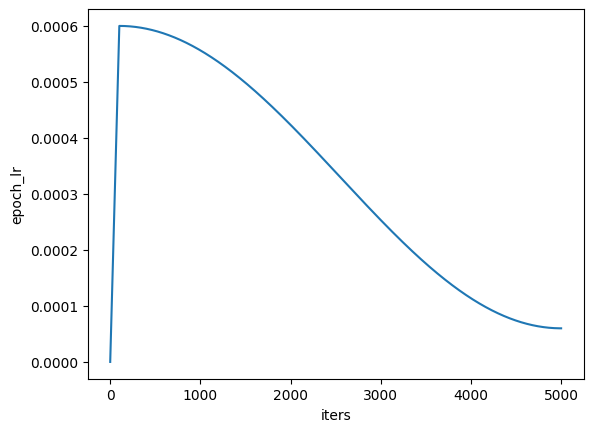

In [18]:
import matplotlib.pyplot as plt

its = [i for i in range(train_config.max_iters)]
lrs = [get_lr(i) for i in its]
plt.xlabel('iters')
plt.ylabel('epoch_lr')
plt.plot(its, lrs)
plt.show()

In [19]:
def estimate_mfu(model, fwdbwd_per_iter, dt):   
    N = model.get_num_params()
    cfg = model.config
    L, H, Q, T = cfg.n_layer, cfg.n_head, cfg.n_embd//cfg.n_head, cfg.block_size
    
    flops_per_token = 6 * N + 12 * L * H * Q * T
    flops_per_fwdbwd = flops_per_token * T
    flops_per_iter = flops_per_fwdbwd * fwdbwd_per_iter
    
    flops_achieved = flops_per_iter * (1.0/dt)
    flops_promised = 29.15e12 # On RTX 4070 half peak flops is 29.15 TFLOPS
    mfu = flops_achieved / flops_promised
    
    return mfu

In [20]:
import time

In [21]:
X, Y = get_batch('train')
t0 = time.time()
iter_num = 0
# local_iter_num = 0
# running_mfu = -1.0

In [22]:
while True:
    
    # determine and set the learning rate for this iteration
    lr = get_lr(iter_num)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    
    # evaluate the loss on train/val sets and write checkpoints
    if iter_num % train_config.eval_interval == 0:
        losses = estimate_loss()
        print('==================================')
        print(Fore.GREEN + f"step {iter_num}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        print(Style.RESET_ALL)
        
        # Use wandb to log the process
        wandb.log({
            "val/loss": losses['val'],
        })        
        
    for micro_step in range(train_config.gradient_accumulation_steps):
        with ctx:
            logits, loss = gpt_model(X, Y)
            # scale the loss to account for gradient accumulation
            loss = loss / train_config.gradient_accumulation_steps
            
        # immediately async prefetch next batch while model is doing the forward pass on the GPU
        X, Y = get_batch('train')
        
        # backward pass, with gradient scaling if training in fp16
        scaler.scale(loss).backward()
    
    # clip the gradient
    if train_config.grad_clip != 0:
        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(gpt_model.parameters(), train_config.grad_clip)
        
    # step the optimizer and scaler if training in fp16
    scaler.step(optimizer)
    scaler.update()
    optimizer.zero_grad(set_to_none=True) # release the gradients 
    
    # timing and logging
    t1 = time.time()
    dt = t1 - t0
    t0 = t1
    if iter_num % train_config.log_interval == 0:
        lossf = loss.item() * train_config.gradient_accumulation_steps
        # if local_iter_num >= 5:
            # mfu = estimate_mfu(gpt_model, model_config.batch_size * train_config.gradient_accumulation_steps, dt)
            # running_mfu = mfu if running_mfu == -1.0 else 0.9 * running_mfu + 0.1 * mfu
        # print(f"iter {iter_num}: loss {lossf:.4f}, time {dt*1000:.2f}ms, mfu {running_mfu*100:.2f}%")
        print(f"iter {iter_num}: loss {lossf:.4f}, time {dt*1e6:.2f}s")
        wandb.log({
            "train/loss": lossf,
        })    
        
    # update iters num
    iter_num += 1
    # local_iter_num += 1
    
    # terminate conditions
    if iter_num > train_config.max_iters:
        break

step 0: train loss 9.5359, val loss 9.5417
iter 0: loss 9.5423, time 4569.28ms
iter 100: loss 6.0004, time 75343.91ms
iter 200: loss 5.3268, time 144082.02ms
iter 300: loss 4.8931, time 211873.01ms
iter 400: loss 4.4415, time 279703.82ms
iter 500: loss 4.3620, time 349435.08ms
iter 600: loss 4.1448, time 419589.60ms
iter 700: loss 4.1996, time 489594.57ms
iter 800: loss 4.1999, time 560152.23ms
iter 900: loss 4.3134, time 630509.46ms
step 1000: train loss 4.0448, val loss 4.2671
iter 1000: loss 4.0031, time 704347.21ms
iter 1100: loss 3.9903, time 773497.06ms
iter 1200: loss 3.7994, time 844033.82ms
iter 1300: loss 3.8288, time 914378.02ms
iter 1400: loss 3.7620, time 984703.51ms
iter 1500: loss 3.9858, time 1054816.05ms
iter 1600: loss 3.9097, time 1124141.13ms
iter 1700: loss 3.6323, time 1194329.61ms
iter 1800: loss 3.6225, time 1263225.35ms
iter 1900: loss 3.8354, time 1331488.28ms
step 2000: train loss 3.7514, val loss 4.0067
iter 2000: loss 3.4924, time 1405089.35ms
iter 2100: lo

In [25]:
checkpoint = {
                'model': gpt_model.state_dict(),
                'optimizer': optimizer.state_dict(),
            }

model_params_dir = 'params'
model_params_name = 'chipogen_model.pth'
print(f"saving model")
torch.save(checkpoint, os.path.join(model_params_dir, model_params_name))
print('save model successfully')

saving model
save model successfully


In [14]:
import numpy as np

str(np.random.randint(0, 65536))

'4716'